In [1]:
import numpy as np
import scipy.linalg as  la
%matplotlib inline
import matplotlib.pyplot as plt
import time
import hamiltonian as hm
import importlib
import scipy.special

# 3-Site system

In [17]:
H3mult = np.array([[0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  1 ,  0 , -1 ,  0 ,  0 , 0],
               [0 , -1 ,  0 ,  0 ,  1 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 , -1 ,  1 , 0],
               [0 ,  1 , -1 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  1 ,  0 ,  0 , -1 , 0],
               [0 ,  0 ,  0 , -1 ,  0 ,  1 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0]])
H3 = H3mult * (2j * np.pi)/(3 * np.sqrt(3))

I = np.array([[ 1,  0],[ 0,  1]])
X = np.array([[ 0,  1],[ 1,  0]])
Y = np.array([[ 0,-1j],[1j,  0]])
Z = np.array([[ 1,  0],[ 0, -1]])

I2 = np.kron(I,I)

In [8]:
vals, vecs = la.eigh(H3)
eners = np.diag(vals)
vecsd = vecs.T.conj()

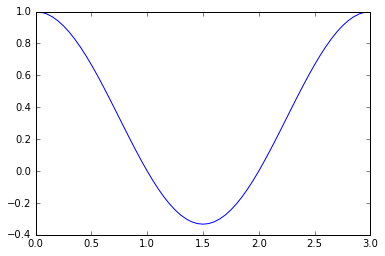

In [11]:
end = 3
n = 20
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    first[i] = np.real(unit3t[1,1])
    second[i] = np.real(unit3t[4,1])
    third[i] = np.real(unit3t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, first)
plt.show()
# print(first)

### 3-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [12]:
# Total time elapsed
end = 3
# Time steps per second
n = 6
N = n*end
A = np.kron(np.kron(Z,I),I)

weight0 = np.empty(N)
weight1 = np.empty(N)
weight2 = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    At = np.linalg.inv(unit3t) @ A @ unit3t
#     print(chop(unit3t),"\n")
    
    weight0[i] = 1 - norm(par_tr(At,0))
    weight1[i] = 1 - norm(par_tr(At,1))
    weight2[i] = 1 - norm(par_tr(At,2))

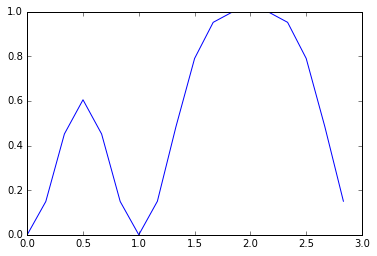

In [13]:
plt.plot(np.arange(N)/n,weight1)
plt.show()

# 5-Site

In [18]:
H5mult = np.kron(H3mult,np.kron(I,I)) + np.kron(np.kron(I,I),H3mult)
H5 = H5mult * (2j * np.pi)/(3 * np.sqrt(3))

In [19]:
vals5, vecs5 = la.eigh(H5)
eners5 = np.diag(vals5)
vecsd5 = vecs5.T.conj()

In [20]:
unit5 = vecs5@np.diag(np.exp(-1j*vals5))@vecsd5
print(chop(unit5[:10,:10]))

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.105  0.944 -0.     0.192  0.    -0.     0.    -0.249  0.   ]
 [ 0.    -0.181  0.105  0.     0.571  0.    -0.     0.     0.754  0.   ]
 [ 0.     0.    -0.     0.202  0.     0.109  0.64   0.     0.    -0.386]
 [ 0.     0.571  0.192  0.    -0.525  0.    -0.     0.     0.571  0.   ]
 [ 0.     0.     0.     0.64   0.    -0.463  0.04   0.     0.     0.294]
 [ 0.    -0.    -0.     0.109 -0.     0.359 -0.463  0.    -0.     0.277]
 [ 0.     0.     0.    -0.     0.     0.     0.     0.202  0.     0.   ]
 [ 0.    -0.249  0.008  0.     0.192  0.    -0.     0.     0.105  0.   ]
 [ 0.     0.     0.    -0.195  0.     0.106  0.086 -0.     0.    -0.253]]


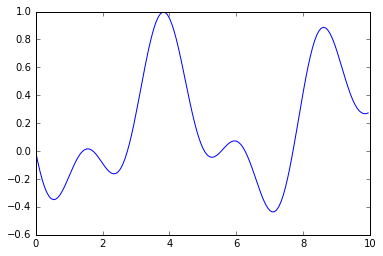

In [21]:
end = 10
n = 15
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    first[i] = np.real(unit5t[1,1])
    second[i] = np.real(unit5t[4,1])
    third[i] = np.real(unit5t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, third)
plt.show()
# print(first)

### 5-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [151]:
# Total time elapsed
end = 2
# Time steps per second
n = 20
N = n*end
A5 = np.kron(np.kron(Z,I),np.kron(np.kron(I,I),I))
B5 = np.kron(np.kron(I,I),np.kron(np.kron(I,I),Z))

weightfore = np.empty((5, N))
weightback = np.empty((5, N))

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    A5t = np.linalg.inv(unit5t) @ A5 @ unit5t
    B5t = np.linalg.inv(unit5t) @ B5 @ unit5t
#     print(chop(unit3t),"\n")
    front = norm(A5t)
    back  = norm(B5t)
    
    for j in range(5):
#         A5t = par_tr(A5t,5-j-1)
        A5t = end_trace(A5t,1)
        B5t = front_trace(B5t,1)
        fronthere = norm(A5t)
        backhere  = norm(B5t)
        weightfore[5-1-j,i] = front - fronthere
        weightback[j,i]     = back  - backhere
        front = fronthere
        back  = backhere

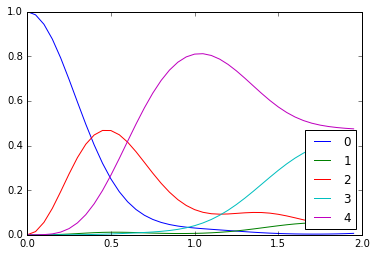

In [152]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightfore[i], label = str(i))
plt.legend(loc=4)
plt.show()

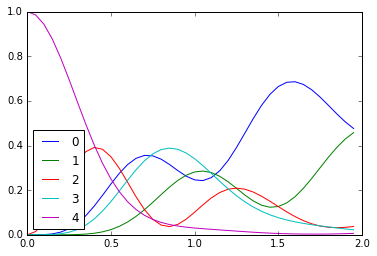

In [153]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightback[i], label = str(i))
plt.legend(loc=3)
plt.show()

# Weight at site

In [23]:
L = 7

H = hm.dense_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    A = np.kron(A,np.array([1,1]))
Alist = hm.arr2list(A)
B = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    B = np.kron(np.array([1,1]),B)
Blist = hm.arr2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = 1
    back  = 1
    
    for j in range(L):
        Ai = hm.par_tr(At,j)
        Bi = hm.par_tr(Bt,L-j-1)
        fronthere = hm.norm(Ai)
        backhere  = hm.norm(Bi)
        weightfore9[L-1-j, i] = 1 - fronthere
        weightback9[j, i]     = 1 - backhere
        front = fronthere
        back  = backhere

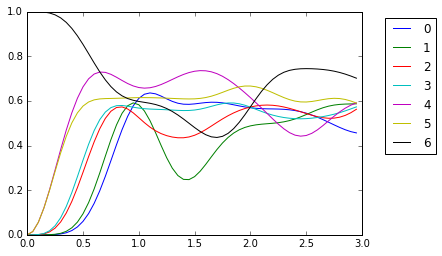

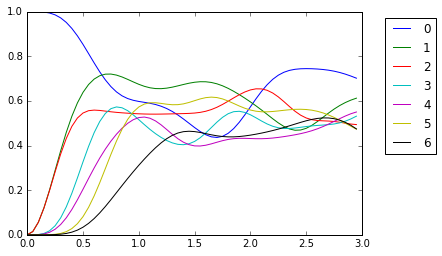

In [24]:
end = (int) (n*3)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

# Saving to File

In [31]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
B = hm.Z
for i in range(L-1):
    B = np.kron(hm.I,B)

weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(np.matmul(vecs,  np.diag(np.exp(-1j*vals*t))), vecsd)
    uninv = np.matmul(np.matmul(vecs,  np.diag(np.exp( 1j*vals*t))), vecsd)
    At    = np.matmul(np.matmul(uninv, A),             unitt)
    Bt    = np.matmul(np.matmul(uninv, B),             unitt)
#     At    = np.matmul(np.matmul(np.linalg.inv(unitt), A),             unitt)
#     Bt    = np.matmul(np.matmul(np.linalg.inv(unitt), B),             unitt)
#     print(chop(unit3t),"\n")
    front = hm.norm(At)
    back  = hm.norm(Bt)
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

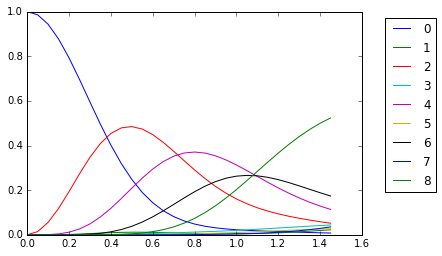

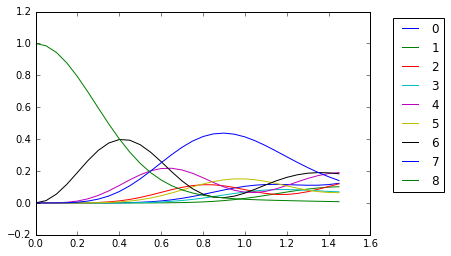

In [34]:
end = (int) (n*1.5)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# Function for getting weights

In [51]:
# Get weights at only some sites at a given time
# Pass (vals, vecs) for faster performance
def get_weights(L, t, sites, here=True, H=None, vals=None, vecs=None):
    # make sure we have vals, vecs
    if (vals is None or vecs is None):
        assert not (H is None)
        vals, vecs = la.eigh(H)
    vecsd = vecs.T.conj()
    
    if (here == False): assert False, 'Only implemented for here'
    
    # Get preliminary stuff
    A = np.array([hm.Z[0,0], hm.Z[1,1]])
    for i in range(L-1):
        A = np.kron(A,np.array([1,1]))
    Alist = hm.arr2list(A)
    B = np.array([hm.Z[0,0], hm.Z[1,1]])
    for i in range(L-1):
        B = np.kron(np.array([1,1]),B)
    Blist = hm.arr2list(B)


    weightfore = np.empty(len(sites))
    weightback = np.empty(len(sites))
    
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = 1
    back  = 1
    
    for j, site in enumerate(sites):
        Aj = hm.par_tr(At,site)
        Bj = hm.par_tr(Bt,site)
        fronthere = hm.norm(Aj)
        backhere  = hm.norm(Bj)
        weightfore[j] = 1 - fronthere
        weightback[j]     = 1 - backhere
    
    return np.array([weightfore, weightback])

In [68]:
# Total time elapsed
end = 2
# Time steps per second
n = 4
N = n*end

weightfore = np.empty((L, N))
weightback = np.empty((L, N))

sites = range(L)
for i in np.arange(N):
    t = i/n
#     (weightfore[:,i], weightback[:,i]) = get_weights(L, t, sites, vecs=vecs, vals=vals)
    (weightfore[:,i], weightback[:,i]) = hm.get_weights(L, t, sites, vecs=vecs, vals=vals)

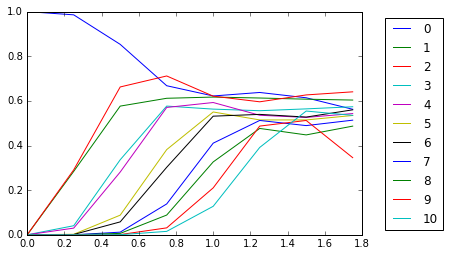

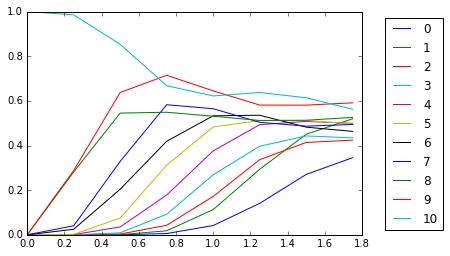

In [69]:
end = (int) (n*2)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

# Basis Permutation
### Alphabetic <-> Constant $S_Z$ bases

In [47]:
# def permutations(L):
#     alph2Sz = np.zeros(2**L, dtype=int)
#     for i in range(2**L):
#         alph2Sz[i] = bin(i).count('1')
#     alph2Sz = alph2Sz.argsort()
#     Sz2alph = np.zeros(2**L, dtype=int)
#     for idx, val in enumerate(alph2Sz):
#         Sz2alph[val] = idx
#     return alph2Sz, Sz2alph

# def mat2list(matrix):
#     L = (int) (np.log2(len(matrix)))
#     alph2Sz, Sz2alph = permutations(L)
#     diag = matrix[alph2Sz]
#     diag = diag[:,alph2Sz]
#     A = []
#     j = 0
#     for i in range(L+1):
#         k = j + (int) (scipy.special.comb(L,i))
#         A.append(diag[j:k, j:k])
#         j = k
#     return A

# def list2mat(A):
#     L = len(A) - 1
#     alph2Sz, Sz2alph = permutations(L)
#     diag = la.block_diag(*A)
#     mat = diag[Sz2alph]
#     return mat[:,Sz2alph]

In [3]:
importlib.reload(hm)

<module 'hamiltonian' from '/Users/cstahl/Documents/Senior/Thesis/python/Hamiltonian/hamiltonian.py'>

True


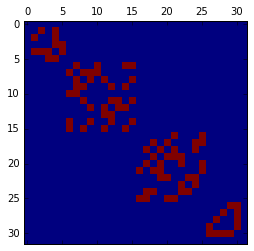

In [50]:
L = 5
H = hm.sparse_H(L)

alph2Sz, Sz2alph = permutations(L)
# print(alph2Sz)

# plt.matshow(np.imag(H))
# plt.show()
# Hdiag = H[alph2Sz]
# Hdiag = Hdiag[:,alph2Sz]
# plt.matshow(np.imag(Hdiag))
# plt.show()

A = mat2list(H)
# for M in A:
#     plt.matshow(np.absolute(M))
#     plt.show()
# Hdiag2 = la.block_diag(*A)
# plt.matshow(np.imag(Hdiag2))
# plt.show()

# H2 = Hdiag2[Sz2alph]
# H2 = H2[:,Sz2alph]
H2 = list2mat(A)

print(np.all(np.isclose(H,H2)))

vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()
M = vecs * vals @ vecsd

M = M[alph2Sz]
M = M[:,alph2Sz]
plt.matshow(np.absolute(M))
plt.show()

In [30]:
def bdiag(B):
    M = B[alph2Sz]
    return M[:,alph2Sz]

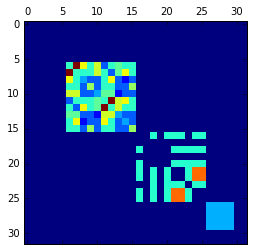

In [35]:
L = 5

alph2Sz, Sz2alph = hm.permutations(L)

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

vecs_list  = hm.mat2list(vecs)
vecsd_list = hm.mat2list(vecsd)
vals_list  = hm.arr2list(vals)

t = 1
unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
ulist = hm.mat2list(unitt)
uinvlist = hm.mat2list(uninv)

ulist_other = []
for idx, val in enumerate(vals_list):
    ulist_other.append(np.dot(vecs_list[idx] * val, vecsd_list[idx]))
    
unitt_other = hm.list2mat(ulist_other)

# plt.matshow(np.absolute(unitt_other))
plt.matshow(np.absolute(bdiag(unitt_other)))
plt.show()

In [23]:
%run -p permute.py

### Including block diagonalization

In [3]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
Alist = hm.mat2list(A)
B = hm.Z
for i in range(L-1):
    B = np.kron(hm.I,B)
Blist = hm.mat2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(np.matmul(uinvlist[idx], val), ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(np.matmul(uinvlist[idx], val), ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = hm.norm(At)
    back  = hm.norm(Bt)
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

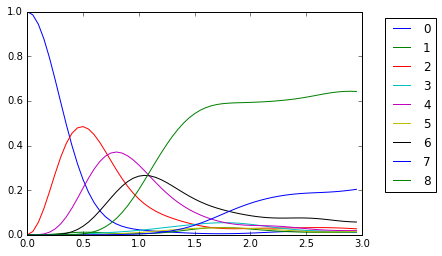

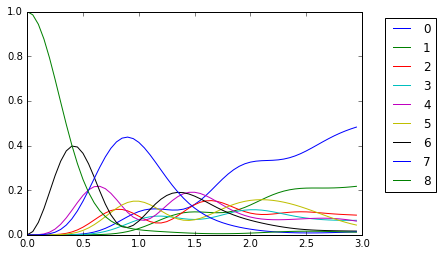

In [4]:
end = (int) (n*3)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

### ...and keeping A, B as lists of arrays

In [7]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    A = np.kron(A,np.array([1,1]))
Alist = hm.arr2list(A)
B = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    B = np.kron(np.array([1,1]),B)
Blist = hm.arr2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.matmul(vecs * np.exp(-1j*vals*t), vecsd)
    uninv = np.matmul(vecs * np.exp( 1j*vals*t), vecsd)
    
    ulist = hm.mat2list(unitt)
    uinvlist = hm.mat2list(uninv)
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = 1
    back  = 1
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

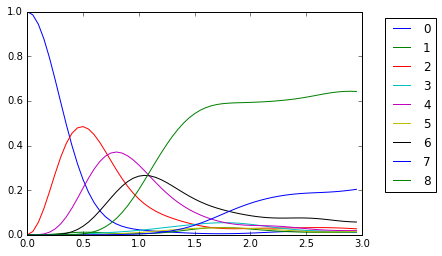

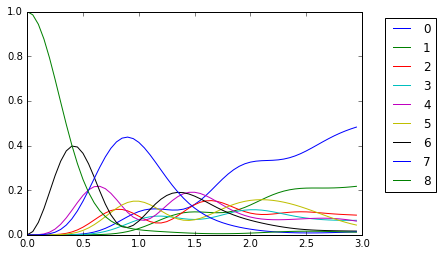

In [8]:
end = (int) (n*3)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

# Block Diagonalize from the beginning

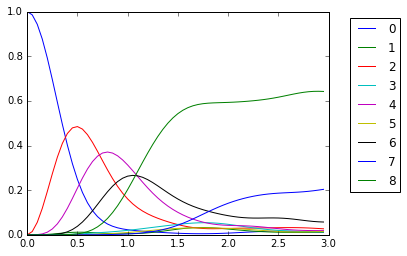

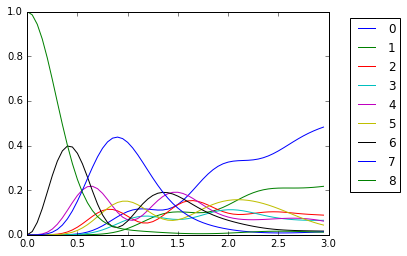

In [7]:
L = 9

H = hm.sparse_H(L)
Hlist = hm.mat2list(H)
vals_list = []
vecs_list = []
vecsd_list = []
for idx, H in enumerate(Hlist):
    vals, vecs = la.eigh(H)
    vals_list.append(vals)
    vecs_list.append(vecs)
    vecsd_list.append(vecs.T.conj())

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    A = np.kron(A,np.array([1,1]))
Alist = hm.arr2list(A)
B = np.array([hm.Z[0,0], hm.Z[1,1]])
for i in range(L-1):
    B = np.kron(np.array([1,1]),B)
Blist = hm.arr2list(B)


weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    ulist = []
    uinvlist = []
    for idx, vecs in enumerate(vecs_list):
        ulist.append(   np.matmul(vecs * np.exp(-1j*vals_list[idx]*t), vecsd_list[idx]))
        uinvlist.append(np.matmul(vecs * np.exp( 1j*vals_list[idx]*t), vecsd_list[idx]))
    
    Atlist = []
    for idx, val in enumerate(Alist):
        Atlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    Btlist = []
    for idx, val in enumerate(Blist):
        Btlist.append(np.matmul(uinvlist[idx] * val, ulist[idx]))
    At = hm.list2mat(Atlist)
    Bt = hm.list2mat(Btlist)
    
    front = 1
    back  = 1
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere
end = (int) (n*3)

ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylim(0,1)
plt.show()

# Timing

### L=9 block diag list

In [80]:
# with block diag list
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :      15.25 s.
  System :       1.13 s.
Wall time:       8.24 s.


In [27]:
# with Alist as arrays
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :      15.00 s.
  System :       1.15 s.
Wall time:       8.24 s.


In [10]:
# Without superfluous norm
%run -t timeHamiltonianlist.py


IPython CPU timings (estimated):
  User   :       5.05 s.
  System :       0.69 s.
Wall time:       2.94 s.


In [3]:
%run -p timeHamiltonianlist.py

### L=11 block diag

In [32]:
%run -t timeHamiltonian11list.py
#          27778 function calls (27773 primitive calls) in 15.123 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    7.388    7.388    7.415    7.415 decomp.py:202(eigh)
#        74    5.385    0.073    5.385    0.073 {built-in method numpy.core.multiarray.matmul}
#         4    0.719    0.180    0.731    0.183 hamiltonian.py:96(mat2list)
#         2    0.465    0.232    0.504    0.252 hamiltonian.py:110(list2mat)


IPython CPU timings (estimated):
  User   :      25.96 s.
  System :       1.39 s.
Wall time:      17.55 s.


In [33]:
# with Alist as arrays
%run -t timeHamiltonian11fulllist.py
#          27756 function calls (27751 primitive calls) in 13.425 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    6.738    6.738    6.771    6.771 decomp.py:202(eigh)
#        50    4.865    0.097    4.865    0.097 {built-in method numpy.core.multiarray.matmul}
#         2    0.436    0.218    0.562    0.281 hamiltonian.py:110(list2mat)
#         2    0.322    0.161    0.327    0.164 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :      24.28 s.
  System :       1.12 s.
Wall time:      15.68 s.


In [10]:
# Without superfluous norm
%run -t timeHamiltonian11fulllist.py

#          27654 function calls (27649 primitive calls) in 12.047 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    7.154    7.154    7.182    7.182 decomp.py:202(eigh)
#        48    2.890    0.060    2.890    0.060 {built-in method numpy.core.multiarray.matmul}
#         2    0.534    0.267    0.588    0.294 hamiltonian.py:110(list2mat)
#         2    0.451    0.225    0.456    0.228 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :      17.77 s.
  System :       0.94 s.
Wall time:      11.34 s.


In [4]:
# Replace unitt calc with dot
%run -t timeHamiltonian11fulllist.py

#          27654 function calls (27649 primitive calls) in 11.187 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    6.631    6.631    6.661    6.661 decomp.py:202(eigh)
#         2    2.139    1.070    2.139    1.070 {built-in method numpy.core.multiarray.dot}
#         2    0.524    0.262    0.651    0.326 hamiltonian.py:110(list2mat)
#         2    0.494    0.247    0.503    0.252 hamiltonian.py:96(mat2list)
#        46    0.470    0.010    0.470    0.010 {built-in method numpy.core.multiarray.matmul}


IPython CPU timings (estimated):
  User   :      17.15 s.
  System :       0.95 s.
Wall time:      11.18 s.


In [13]:
# Replace everything but unitt calc with dot
%run -t timeHamiltonian11fulllist.py

#          27654 function calls (27649 primitive calls) in 11.707 seconds

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    7.053    7.053    7.079    7.079 decomp.py:202(eigh)
#         2    2.389    1.194    2.389    1.194 {built-in method numpy.core.multiarray.matmul}
#        46    0.614    0.013    0.614    0.013 {built-in method numpy.core.multiarray.dot}
#         2    0.421    0.210    0.459    0.229 hamiltonian.py:110(list2mat)
#         2    0.365    0.183    0.373    0.187 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :      17.45 s.
  System :       0.99 s.
Wall time:      11.32 s.


In [8]:
# Now with even more lists (Don't diagonalize the whole Hamiltonian)
%run -t timeHamiltonian11fulllist.py

#          23955 function calls (23950 primitive calls) in 1.991 seconds

#    Ordered by: internal time

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#        70    0.564    0.008    0.564    0.008 {built-in method numpy.core.multiarray.matmul}
#         2    0.333    0.167    0.370    0.185 hamiltonian.py:110(list2mat)
#        12    0.251    0.021    0.258    0.022 decomp.py:202(eigh)
#         1    0.156    0.156    0.159    0.159 hamiltonian.py:96(mat2list)
#         1    0.141    0.141    0.356    0.356 hamiltonian.py:25(sparse_H)


IPython CPU timings (estimated):
  User   :       2.59 s.
  System :       0.57 s.
Wall time:       2.17 s.


In [4]:
# replace norm with dot -> All matmuls are about the same
%run -t timeHamiltonian11fulllist.py

#          23955 function calls (23950 primitive calls) in 2.063 seconds

#    Ordered by: internal time

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#        22    0.341    0.015    0.341    0.015 {built-in method numpy.core.multiarray.dot}
#         2    0.303    0.151    0.340    0.170 hamiltonian.py:110(list2mat)
#        12    0.234    0.020    0.241    0.020 decomp.py:202(eigh)
#        48    0.185    0.004    0.185    0.004 {built-in method numpy.core.multiarray.matmul}
#         1    0.170    0.170    0.436    0.436 hamiltonian.py:25(sparse_H)
#         1    0.157    0.157    0.160    0.160 hamiltonian.py:96(mat2list)


IPython CPU timings (estimated):
  User   :       2.70 s.
  System :       0.67 s.
Wall time:       2.37 s.


In [5]:
%run -p timeHamiltonian11fulllist.py

In [2]:
%run -p weights.py

In [4]:
Z = hm.Z
Y = hm.Y
X = hm.Z
I = hm.I

In [6]:
Z3 = hm.tensor(Z, I, I) + hm.tensor(I, Z, I) + hm.tensor(I, I, Z)
X3 = hm.tensor(X, I, I) + hm.tensor(I, X, I) + hm.tensor(I, I, X)
Y3 = hm.tensor(Y, I, I) + hm.tensor(I, Y, I) + hm.tensor(I, I, Y)
print(Z3)
print(hm.chop(Z3@Z3 + X3@X3 + Y3@Y3))

[[ 3  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -3]]
[[21  0  0 -2  0 -2 -2  0]
 [ 0  5  2  0  2  0  0 -2]
 [ 0  2  5  0  2  0  0 -2]
 [-2  0  0  5  0  2  2  0]
 [ 0  2  2  0  5  0  0 -2]
 [-2  0  0  2  0  5  2  0]
 [-2  0  0  2  0  2  5  0]
 [ 0 -2 -2  0 -2  0  0 21]]


In [3]:
print(hm.sparse_Hmult(3))

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  1  0 -1  0  0  0]
 [ 0 -1  0  0  1  0  0  0]
 [ 0  0  0  0  0 -1  1  0]
 [ 0  1 -1  0  0  0  0  0]
 [ 0  0  0  1  0  0 -1  0]
 [ 0  0  0 -1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [6]:
X = hm.X
Y = hm.Y
Z = hm.Z
I = hm.I
X1 = t(X,I,I)
Y1 = t(Y,I,I)
Z1 = t(Z,I,I)
X2 = t(I,X,I)
Y2 = t(I,Y,I)
Z2 = t(I,Z,I)
X3 = t(I,I,X)
Y3 = t(I,I,Y)
Z3 = t(I,I,Z)
t = hm.tensor
print(hm.chop(1j *(X1@Y2@Z3 - X1@Z2@Y3 + Y1@Z2@X3 - Y1@X2@Z3 + Z1@X2@Y3 - Z1@Y2@X3)))

[[ 0  0  0  0  0  0  0  0]
 [ 0  0 -2  0  2  0  0  0]
 [ 0  2  0  0 -2  0  0  0]
 [ 0  0  0  0  0  2 -2  0]
 [ 0 -2  2  0  0  0  0  0]
 [ 0  0  0 -2  0  0  2  0]
 [ 0  0  0  2  0 -2  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [12]:
I = hm.I
X = hm.X
Y = hm.Y
Z = hm.Z
L = 9
sites = np.arange(L)
At = hm.tensor(I,Z,I,I,I,I,I,I,I) + \
     hm.tensor(I,X,I,I,I,I,I,I,I) + \
     hm.tensor(I,Y,I,I,I,I,I,I,I) + \
     hm.tensor(I,I,I,I,I,I,I,I,I)
Bt = hm.tensor(Z,I,Z,X,I,I,I,I,I) + \
     hm.tensor(Z,I,X,Y,I,I,I,I,I) + \
     hm.tensor(Z,I,Y,I,I,I,I,I,I) + \
     hm.tensor(Z,I,I,Z,I,I,I,I,I)

for j, site in enumerate(sites):
    Aj = hm.par_tr(At/2,site)
    Bj = hm.par_tr(Bt/2,site)
    fronthere = hm.norm(Aj)
    backhere  = hm.norm(Bj)
    print(1 - fronthere)
    print(1 - backhere)

0.0
1.0
0.75
0.0
0.0
0.75
0.0
0.75
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [23]:
L = 2
sites = np.arange(L)
At =(hm.tensor(X,X) + hm.tensor(X,Y) + \
     hm.tensor(X,Z) + hm.tensor(X,I) + \
     hm.tensor(Y,X) + hm.tensor(Y,Y) + \
     hm.tensor(Y,Z) + hm.tensor(Y,I) + \
     hm.tensor(Z,X) + hm.tensor(Z,Y) + \
     hm.tensor(Z,Z) + hm.tensor(Z,I) + \
     hm.tensor(I,X) + hm.tensor(I,Y) + \
     hm.tensor(I,Z) + hm.tensor(I,I))/4
print(At)
print(hm.norm(At))
print()
Bt =(hm.tensor(X,X) + hm.tensor(X,Y) + \
     hm.tensor(X,Z) + hm.tensor(X,I) + \
     hm.tensor(Y,X) + hm.tensor(Y,Y) + \
     hm.tensor(Y,Z) + hm.tensor(Y,I))
print(Bt)
print(hm.norm(Bt))
print()

for j, site in enumerate(sites):
    Aj = hm.par_tr(At/2,site)
    print(Aj)
#     Bj = hm.par_tr(Bt/2,site)
    fronthere = hm.norm(Aj)
#     backhere  = hm.norm(Bj)
    print(fronthere)
#     print(backhere)

[[ 1.0+0.j   0.5-0.5j  0.5-0.5j  0.0-0.5j]
 [ 0.5+0.5j  0.0+0.j   0.5+0.j   0.0+0.j ]
 [ 0.5+0.5j  0.5+0.j   0.0+0.j   0.0+0.j ]
 [ 0.0+0.5j  0.0+0.j   0.0+0.j   0.0+0.j ]]
1.0

[[ 0.+0.j  0.+0.j  2.-2.j  0.-2.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j]
 [ 2.+2.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+2.j  0.+0.j  0.+0.j  0.+0.j]]
8.0

[[ 0.250+0.j     0.125-0.125j]
 [ 0.125+0.125j  0.000+0.j   ]]
0.0625
[[ 0.250+0.j     0.125-0.125j]
 [ 0.125+0.125j  0.000+0.j   ]]
0.0625
